<a href="https://colab.research.google.com/github/Vineet2107/Customising-models-with-TensorFlow-2-/blob/main/Coding_Tutorial_Week4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.5.0


# Model subclassing and custom training loops

 ## Coding tutorials
 #### [1. Model subclassing](#coding_tutorial_1)
 #### [2. Custom layers](#coding_tutorial_2)
 #### [3. Automatic differentiation](#coding_tutorial_3)
 #### [4. Custom training loops](#coding_tutorial_4)
 #### [5. tf.function decorator](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Model subclassing

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Softmax, concatenate

#### Create a simple model using the model subclassing API

In [4]:
# Build the model

class MyModel(Model):

  def __init__(self):
      super(MyModel, self).__init__()
      self.dense_1 = Dense(64, activation='relu')
      self.dense_2 = Dense(10)
      self.dense_3 = Dense(5)
      self.softmax = Softmax()

  def call(self, inputs):
      x = self.dense_1(inputs)
      y1 = self.dense_2(inputs)
      y2 = self.dense_3(y1)
      concat = concatenate([x, y2])
      return self.softmax(concat)

In [5]:
# Print the model summary

model = MyModel()
model(tf.random.uniform([1,10]))
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  704       
_________________________________________________________________
dense_1 (Dense)              multiple                  110       
_________________________________________________________________
dense_2 (Dense)              multiple                  55        
_________________________________________________________________
softmax (Softmax)            multiple                  0         
Total params: 869
Trainable params: 869
Non-trainable params: 0
_________________________________________________________________


***
<a id="coding_tutorial_2"></a>
## Custom layers

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

#### Create custom layers

In [7]:
# Create a custom layer

class MyLayer(Layer):
    
    def __init__(self, units, input_dim):
        super(MyLayer, self).__init__()
        self.W = self.add_weight(shape=(input_dim, units),
                                 initializer='random_normal')
        self.b = self.add_weight(shape=(units,),
                                 initializer='zeros')
        
        def call(self, input):
            return tf.matmul(inputs, self.w)+self.b
dense_layer = MyLayer(3,5)
x = tf.ones((1,5))
print(dense_layer(x))
print(dense_layer.weights)

tf.Tensor([[1. 1. 1. 1. 1.]], shape=(1, 5), dtype=float32)
[<tf.Variable 'Variable:0' shape=(5, 3) dtype=float32, numpy=
array([[-0.01898911,  0.072402  ,  0.01793057],
       [-0.06924512,  0.03352962,  0.03701708],
       [-0.02909693, -0.00956737, -0.100604  ],
       [-0.07509243,  0.05560825, -0.04364246],
       [ 0.06294969,  0.00042775, -0.08723205]], dtype=float32)>, <tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>]


In [8]:
# Specify trainable weights
class MyLayer(Layer):
    
    def __init__(self, units, input_dim):
        super(MyLayer, self).__init__()
        self.W = self.add_weight(shape=(input_dim, units),
                                 initializer='random_normal',
                                 trainable=False)
        self.b = self.add_weight(shape=(units,),
                                 initializer='zeros')
        
        def call(self, input):
            return tf.matmul(inputs, self.w)+self.b
dense_layer = MyLayer(3,5)


In [9]:
print('trainable weights:', len(dense_layer.trainable_weights))
print('non-trainable weights:', len(dense_layer.non_trainable_weights))

trainable weights: 1
non-trainable weights: 1


In [18]:
# Create a custom layer to accumulate means of output values

class MyLayerMean(Layer):
    
    def __init__(self, units, input_dim):
        super(MyLayerMean, self).__init__()
        self.W = self.add_weight(shape=(input_dim, units),
                                 initializer='random_normal')
        self.b = self.add_weight(shape=(units,),
                                 initializer='zeros')
        self.sum_activation = tf.Variable(initial_value=tf.zeros((units,)),
                                          trainable=False)
        self.number_call = tf.Variable(initial_value=0,
                                       trainable=False)
        
    def call(self, input):
        activation = tf.matmul(input, self.W)+self.b
        self.sum_activation.assign_add(tf.reduce_sum(activation, axis=0))
        self.number_call.assign_add(input.shape[0])
        return activation, self.sum_activation / tf.cast(self.number_call, tf.float32)    
dense_layer = MyLayerMean(3,5)

In [19]:
# Test the layer

y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())
y, activation_means = dense_layer(tf.ones((1, 5)))
print(activation_means.numpy())

[-0.08605132  0.25168934  0.0192831 ]
[-0.08605132  0.25168934  0.0192831 ]


In [20]:
# Create a Dropout layer as a custom layer

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)

#### Implement the custom layers into a model

In [23]:
# Build the model using custom layers with the model subclassing API

class MyModel(Model):

    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = MyLayer(units_1, input_dim_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2, units_1)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3, units_2)
        self.softmax = Softmax()
           
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        return self.softmax(x)

In [24]:
# Instantiate a model object

model = MyModel(64,10000,64,46)
print(model(tf.ones((1, 10000))))
model.summary()

tf.Tensor(
[[6.8831737e-06 6.8831737e-06 6.8831737e-06 ... 6.8831737e-06
  6.8831737e-06 6.8831737e-06]], shape=(1, 10000), dtype=float32)
Model: "my_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_layer_2 (MyLayer)         multiple                  640064    
_________________________________________________________________
my_dropout (MyDropout)       multiple                  0         
_________________________________________________________________
my_layer_3 (MyLayer)         multiple                  4160      
_________________________________________________________________
my_dropout_1 (MyDropout)     multiple                  0         
_________________________________________________________________
my_layer_4 (MyLayer)         multiple                  2990      
_________________________________________________________________
softmax_1 (Softmax)          multiple            

***
<a id="coding_tutorial_3"></a>
## Automatic differentiation

In [25]:
import numpy as np
import matplotlib.pyplot as plt

#### Create synthetic data

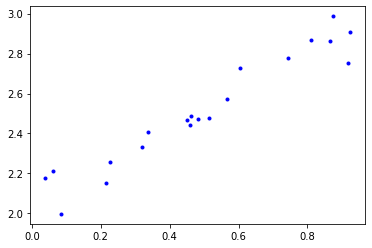

In [26]:
# Create data from a noise contaminated linear model

def MakeNoisyData(m, b, n=20):
    x = tf.random.uniform(shape=(n,))
    noise = tf.random.normal(shape=(len(x),), stddev=0.1)
    y = m * x + b + noise
    return x, y

m=1
b=2
x_train, y_train = MakeNoisyData(m,b)
plt.plot(x_train, y_train, 'b.')

#### Define a linear regression model

In [27]:
from tensorflow.keras.layers import Layer

In [28]:
# Build a custom layer for the linear regression model

class LinearLayer(Layer):

    def __init__(self):
        super(LinearLayer, self).__init__()
        self.m = self.add_weight(shape=(1,),
                                initializer='random_normal')
        self.b = self.add_weight(shape=(1,),
                                initializer='zeros')
    
    def call(self, inputs):
        return self.m+self.b
linear_regression = LinearLayer()

print(linear_regression(x_train))
print(linear_regression.weights)
    

tf.Tensor([0.04819635], shape=(1,), dtype=float32)
[<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.04819635], dtype=float32)>, <tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


#### Define the loss function

In [29]:
# Define the mean squared error loss function

def SquaredError(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true)) 

starting_loss = SquaredError(linear_regression(x_train), y_train)
print("Starting loss", starting_loss.numpy())

Starting loss 6.172035


#### Train and plot the model

In [30]:
# Implement a gradient descent training loop for the linear regression model

learning_rate = 0.05
steps = 25

for i in range(steps):
   with tf.GradientTape() as tape:
       predictions = linear_regression(x_train)
       loss = SquaredError(predictions, y_train)
   gradients = tape.gradient(loss, linear_regression.trainable_variables)

   linear_regression.m.assign_sub(learning_rate*gradients[0])
   linear_regression.m.assign_sub(learning_rate*gradients[0])

   print('Step %d, Loss %f' % (i, loss.numpy()))
   

Step 0, Loss 6.172035
Step 1, Loss 3.977543
Step 2, Loss 2.573068
Step 3, Loss 1.674204
Step 4, Loss 1.098932
Step 5, Loss 0.730757
Step 6, Loss 0.495125
Step 7, Loss 0.344321
Step 8, Loss 0.247806
Step 9, Loss 0.186037
Step 10, Loss 0.146504
Step 11, Loss 0.121203
Step 12, Loss 0.105011
Step 13, Loss 0.094648
Step 14, Loss 0.088015
Step 15, Loss 0.083770
Step 16, Loss 0.081054
Step 17, Loss 0.079315
Step 18, Loss 0.078202
Step 19, Loss 0.077490
Step 20, Loss 0.077034
Step 21, Loss 0.076743
Step 22, Loss 0.076556
Step 23, Loss 0.076437
Step 24, Loss 0.076360


m:1,  trained m:[2.5078382]
b:2,  trained b:[0.]


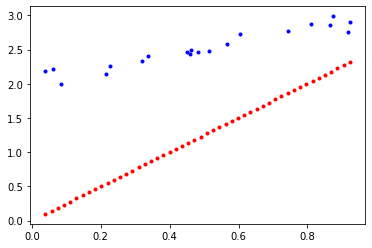

In [31]:
# Plot the learned regression model

print("m:{},  trained m:{}".format(m,linear_regression.m.numpy()))
print("b:{},  trained b:{}".format(b,linear_regression.b.numpy()))

plt.plot(x_train, y_train, 'b.')

x_linear_regression=np.linspace(min(x_train), max(x_train),50)
plt.plot(x_linear_regression, linear_regression.m*x_linear_regression+linear_regression.b, 'r.')

***
<a id="coding_tutorial_4"></a>
## Custom training loops

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [33]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

In [34]:
# Define the custom layers and model

class MyLayer(Layer):
    
    def __init__(self, units, input_dim):
        super(MyLayer, self).__init__()
        self.W = self.add_weight(shape=(input_dim, units),
                                 initializer='random_normal')
        self.b = self.add_weight(shape=(units,),
                                 initializer='zeros')
        
    def call(self, input):
            return tf.matmul(inputs, self.w)+self.b
class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        # Define forward pass for dropout layer
        return tf.nn.dropout(inputs, rate=self.rate)
class MyModel(Model):

    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        # Define layers
        self.layer_1 = Mylayer(units_1, input_dim_1)
        self.dropout_1 = MyDropout(0.5)
        self.layer_2 = MyLayer(units_2, units_1)
        self.dropout_2 = MyDropout(0.5)
        self.layer_3 = MyLayer(units_3, units_2)
        self.softmax = Softmax()
           
    def call(self, inputs):
        # Define forward pass
        x = self.layer_1(inputs)
        x = tf.nn.relu(x)
        x = self.dropout_1(x)
        x = self.layer_2(x)
        x = tf.nn.relu(x)
        x = self.dropout_2(x)
        x = self.layer_3(x)
        return self.softmax(x)


#### Load the reuters dataset and define the class_names 

In [35]:
# Load the dataset

from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

2113536/2110848 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:143: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:144: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [36]:
# Print the class of the first sample

print("Label: {}".format(class_names[train_labels[0]]))

Label: earn


#### Get the dataset word index

In [37]:
# Load the Reuters word index

word_to_index = reuters.get_word_index()

invert_word_index = dict([(value, key) for (key, value) in word_to_index.items()])
text_news = ' '.join([invert_word_index.get(i - 3, '?') for i in train_data[0]])

557056/550378 [==============================] - 0s 0us/step


In [38]:
# Print the first data example sentence



#### Preprocess the data

In [39]:
# Define a function that encodes the data into a 'bag of words' representation

def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(train_data)
x_test = bag_of_words(test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Shape of x_train: (8982, 10000)
Shape of x_test: (2246, 10000)


#### Define the loss function and optimizer



In [40]:
# Define the categorical cross entropy loss and Adam optimizer

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name:
                kernel_variables.append(w)
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k)) for k in kernel_variables])
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Train the model

In [41]:
# Define a function to compute the forward and backward pass

def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [42]:
# Implement the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

    
    
print("Duration :{:.3f}".format(time.time() - start_time))

Duration :0.000


#### Evaluate the model

In [43]:
# Create a Dataset object for the test set

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(32)

In [44]:
# Collect average loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [45]:
# Loop over the test set and print scores

from tensorflow.keras.utils import to_categorical

for x, y in test_dataset:
    # Optimize the model
    loss_value = loss(model, x, y, weight_decay)    
    # Compute current loss
    epoch_loss_avg(loss_value)  
    # Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

NameError: ignored

#### Plot the learning curves

NameError: ignored

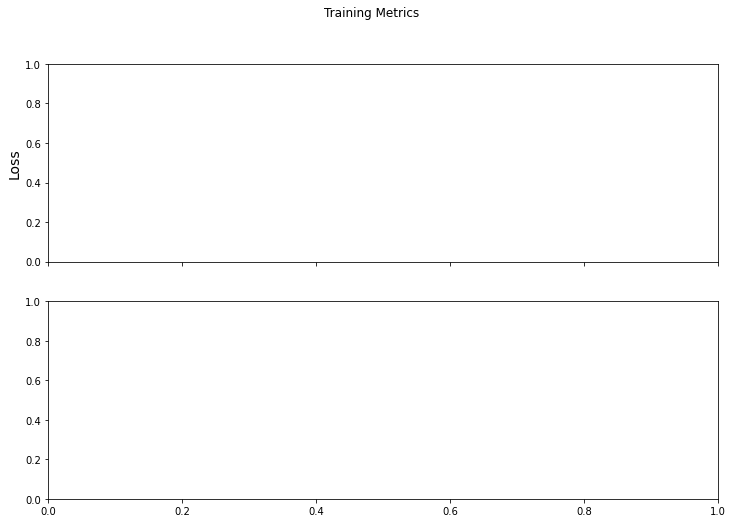

In [46]:
# Plot the training loss and accuracy

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Predict from the model

In [47]:
# Get the model prediction for an example input

predicted_label = np.argmax(model(x_train[np.newaxis,0]),axis=1)[0]
print("Prediction: {}".format(class_names[predicted_label]))
print("     Label: {}".format(class_names[train_labels[0]]))

Prediction: veg-oil
     Label: earn


***
<a id="coding_tutorial_5"></a>
## tf.function decorator

In [48]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [49]:
# Initialize a new model



#### Redefine the grad function using the @tf.function decorator

In [ ]:
# Use the @tf.function decorator



#### Train the model

In [ ]:
# Re-run the training loop



#### Print the autograph code

In [ ]:
# Use tf.autograph.to_code to see the generated code

